### Dynamic Programming Code for Optimal CP Detection

Implements Levy-Leduc Code to determine optimal number of changepoints across a candidate set 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
def map_intervals(Y,indices):
    """ Maps the indices of the candidate changepoints to a dictionary of intervals
    """
    intervals={}
    for i in range(len(indices)-1):
        intervals[i]=([indices[i],indices[i+1]])
   
    return intervals


In [ ]:
# TO:DO: Consider constraining continuity of the polynomial instead of mse 

def best_fit_polynomial(Y,interval,order=1):
    """ Fits a polynomial of order k to the data Y across a given interval
    """
    # partitions x and y of interval 
    y=Y[interval[0]:interval[1]]
    x_range=np.arange(interval[0],interval[1],1)

    # fit polynomial of order k to data
    poly_coef=np.polyfit(x_range,y,order)
    polynomial=poly_coef.dot(np.vstack([x_range**i for i in range(order,-1,-1)]))
    
    # mean squared error of fit
    mse=np.mean((y-polynomial)**2)

    return mse

In [ ]:
def compute_J(Y,indices,cp_mappings,order):
    """ Evaluate cost matrix between each nested pair of changepoints
    """
    
    k=len(indices)-1
    mapping_indices=np.arange(k)

    # initialize cost matrix
    cost_matrix=np.zeros((k,k))
    
    # evaluate cost matrix, looping over nested pairs of merged intervals
    for i in range(len(mapping_indices)):
        for j in range(i,len(mapping_indices)):
          
            interval=[cp_mappings[i][0],cp_mappings[j][1]]
            cost_matrix[i,j]=best_fit_polynomial(Y,interval,order=order)

    return cost_matrix

In [ ]:
def compute_V(cost_matrix,K_max,indices):
    """ Computes the optimal cost and changepoint locations
    """
   
    k=len(indices)-1
    
    # initialize optimal cost and optimal location matrices
    optimal_cost=np.zeros((K_max+1,k))
    optimal_loc=np.zeros((K_max,k))
    
    
    # no changepoints; best RSE is the sum of squared errors on interval
    for i in range(k):
        optimal_cost[0,i]=cost_matrix[0,i]
  
    # loop over number of possible changepoints calculating optimal cost and location of indices 
    # utilizes dynamic programming structure to build solution from subproblems solution 
    for k_i in range(1,K_max+1):
        for j in range(k_i+1,k+1):
      
            optimal_cost[k_i,j-1]=np.min(optimal_cost[k_i-1,k_i-1:j-1]+cost_matrix[k_i:j,j-1])
            ind=np.argmin(optimal_cost[k_i-1,k_i-1:j-1]+cost_matrix[k_i:j,j-1])
            optimal_loc[k_i-1,j-1]=ind+k_i-1
 
    return optimal_loc

In [ ]:
def optimal_segmentation(optimal_loc,indices,K_max):
    """ Computes the optimal segmentation based on recursive RSE
    """
    
    all_loc=optimal_loc.copy()
    k=len(indices)-1

    # dictionary keyed by potential cp, values are cps that are optimal for that k_i
    total_loc={}

    for k_i in range(1,K_max+1):
        total_loc[k_i-1]=np.zeros(k_i)
        total_loc[k_i-1][k_i-1]=all_loc[k_i-1,k-1]
        for i in range(k_i-1,0,-1):
            total_loc[k_i-1][i-1]=all_loc[i-1,int(total_loc[k_i-1][i])]

    return total_loc

In [ ]:
def convert_observed_cp(optimal_segment,indices):
    """Converts the optimal changepoints to the observed indices
    """
    all_segments=optimal_segment.copy()
    
    # keys by number of points 
    for i in range(len(all_segments)):
        indices_dict=dict(zip([i for i in range(0,len(indices))],indices))
        
        all_segments[i]=[indices_dict[int(i)+1] for i in all_segments[i]]
    all_segments={i+1:all_segments[i] for i in range(len(all_segments))}
    return all_segments

In [194]:

def dp_solver(Y,indices,K_max,k=1):
    """ DP Management function to determine optimal changepoints per fixed size
    """

    if K_max>len(indices):
        print("K_max must be less than or equal to the number of candidate changepoints")
        K_max=len(indices)

    indices=np.unique(np.concatenate([[0],indices,[len(Y)]]))
    print("Indices are {}".format(indices))

    # map the indices to the intervals of the data
    cp_mappings=map_intervals(Y,indices)
    
    # Initialize cost matrix
    cost_matrix=compute_J(Y,indices,cp_mappings,k)

    # Compute optimal cost and changepoint locations
    optimal_loc=compute_V(cost_matrix,K_max,indices)
    
    # Compute optimal segmentation
    optimal_segment=optimal_segmentation(optimal_loc,indices,K_max)

    optimal_indices=convert_observed_cp(optimal_segment,indices)

    return optimal_indices


In [234]:
def test_dp():
    """ Prep dataset to test dynamic programming recursion
    """
    n=250
    k=5
    x=np.arange(0,n,1)
    y=np.empty(n)

    sample_variance=0.5
    
    n1,n2,n3,n4,n5=np.arange(0,n,n/k).astype(int)
    
    def generate_noise(samples,sample_variance):
        return np.random.normal(scale=sample_variance,size=n)
    
    y[:n2]=0.1*x[:n2]+2
    y[n2:n3]=-0.05*x[n2:n3]+9.5
    y[n3:n4]=0.05*x[n3:n4]-0.5

    y[n4:n5]=-0.05*x[n4:n5]+14.5
    y[n5:]=0.25*x[n5:]-45.5

    true_cp=np.array([n2,n3,n4,n5])
    noisy_cp=np.array([35,n2,75,n3,125,130,135,141,n4,167,n5])
    
    return x,y+0.5*generate_noise(n,sample_variance),noisy_cp,true_cp

### Test Cases

1. Pass in K_max=n where n is number of changepoints. Optimal solution for k_i=K_max should be original CP set

In [235]:
x,y,noisy_cp,true_cp=test_dp()
n=len(noisy_cp)

optimal_indices=dp_solver(y,noisy_cp,K_max=n,k=1)
optimal_indices

Indices are [  0  35  50  75 100 125 130 135 141 150 167 200 250]


{1: [200],
 2: [35, 200],
 3: [35, 135, 200],
 4: [50, 100, 150, 200],
 5: [50, 100, 150, 167, 200],
 6: [50, 100, 125, 130, 150, 200],
 7: [50, 100, 125, 130, 135, 150, 200],
 8: [50, 100, 125, 130, 135, 150, 167, 200],
 9: [50, 75, 100, 125, 130, 135, 150, 167, 200],
 10: [50, 75, 100, 125, 130, 135, 141, 150, 167, 200],
 11: [35, 50, 75, 100, 125, 130, 135, 141, 150, 167, 200]}

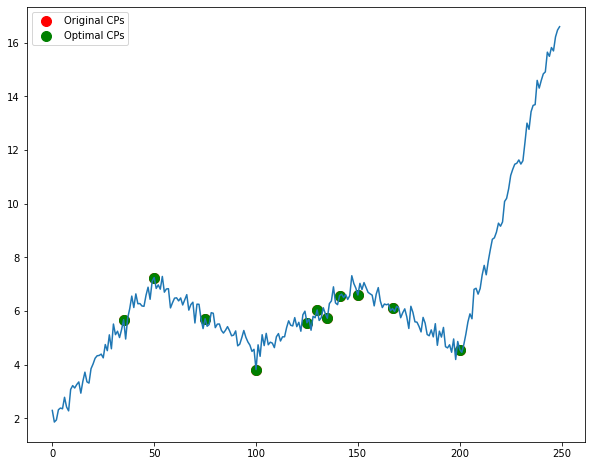

In [236]:
fig,ax=plt.subplots(1,1,figsize=(10,8))
ax.plot(x,y)
ax.scatter(x[noisy_cp],y[noisy_cp],c='r',s=100,label='Original CPs')
ax.scatter(x[optimal_indices[n]],y[optimal_indices[n]],c='g',s=100,label='Optimal CPs')
ax.legend()

### Model Selection

In [237]:
def generalized_cross_validation(optimal_indices,Y,order=1):
    """ Determines optimal number of changepoints based on generalized cross validation """

    mse_dict={}
    gcv_dict={}
    
    # confirm below params are optimal
    c=3
    r=order+2

    for k_i, cps in optimal_indices.items():

        # pad cps
        cps=np.unique(np.concatenate([[0],cps,[len(Y)]]))

        fixed_intervals=map_intervals(Y,cps)
      
        

        K=len(cps)
        M=r+c*K

        fixed_mse=0
        # compute the sum of squared errors of best fitted polynomial each interval
        
        for inter in list(fixed_intervals.values()):
            mse=best_fit_polynomial(Y,inter)
            fixed_mse+=mse
        
        mse_dict[k_i]=fixed_mse
        gcv_dict[k_i]=fixed_mse/(1-(M/len(Y))**2)

    sorted_mse=sorted(mse_dict.items(),key=lambda x: x[1])
    sorted_gcv=sorted(gcv_dict.items(),key=lambda x: x[1])
    return sorted_mse, sorted_gcv

In [238]:
generalized_cross_validation(optimal_indices,y)

([(4, 0.30370377884604144),
  (5, 0.34770445541810957),
  (6, 0.3890628648494881),
  (7, 0.42661559565381046),
  (8, 0.47061627222587854),
  (9, 0.5188942574492225),
  (10, 0.5912307553340956),
  (3, 0.6063325569421415),
  (2, 0.6403051153194597),
  (11, 0.680007527164374),
  (1, 1.150166741836451)],
 [(4, 0.3058619406996179),
  (5, 0.3509387065375597),
  (6, 0.3936544503584693),
  (7, 0.4328486157201811),
  (8, 0.478961700902402),
  (9, 0.5298818882846938),
  (10, 0.6059778318499972),
  (3, 0.6094921643219866),
  (2, 0.642618542070915),
  (11, 0.6997574823461106),
  (1, 1.1528228456728813)])

### Optimal Selected CP

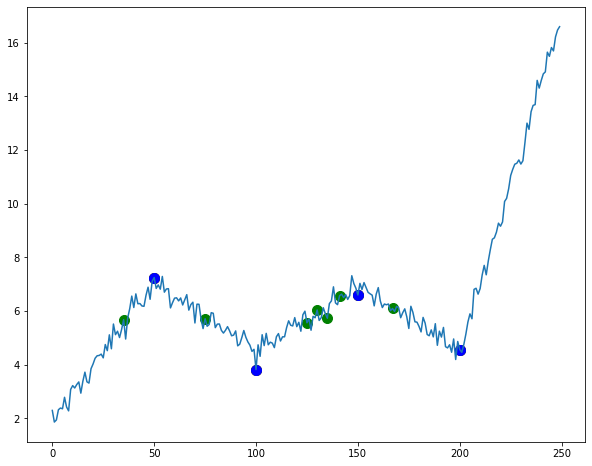

In [245]:
fig,ax=plt.subplots(1,1,figsize=(10,8))
ax.plot(x,y)
ax.scatter(x[true_cp],y[true_cp],c='r',s=100,label='True CPs')
ax.scatter(x[noisy_cp],y[noisy_cp],c='g',s=100,label='Noisy CPs')
ax.scatter(x[optimal_indices[4]],y[optimal_indices[4]],c='b',s=100,label='Optimally Selected CPs')

### Able to Recover all of the original CP

In [246]:
true_cp

array([ 50, 100, 150, 200])

In [247]:
optimal_indices[4]

[50, 100, 150, 200]